# Music Genre Classification

## Introduction


In this notebook we will return to the song lyrics dataset and compare the Bag of Words model we trained previously with fine-tuning a pretrained Transformer model (BERT).

**We will demonstrate that fine-tuning a pretrained model can achieve excellent accuracy with vastly fewer training samples**.


In [ ]:
import os
os.environ['KERAS_BACKEND'] = 'tensorflow'

In [ ]:
import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
keras.utils.set_random_seed(42)

## Retrieving and preparing the Data


In [ ]:
train_url = "https://www.dropbox.com/scl/fi/ito6bnl2yaf1uw0uqibzf/lyric_genre_train.csv?rlkey=04dkn5un2djza8x0bdmfnlw3u&st=y47qh8i4&dl=1"
val_url = "https://www.dropbox.com/scl/fi/xmywjzqsaa8n5sn1bs0t9/lyric_genre_val.csv?rlkey=hggbeo0s1iaxjpa6z80429xl9&st=6i7d8eau&dl=1"
test_url = "https://www.dropbox.com/scl/fi/fnocl69w9ojs9s5zb0xvf/lyric_genre_test.csv?rlkey=z4hjopw7vaihoh948cbb5mvdp&st=xwond7dp&dl=1"

In [ ]:
# Read data from URL

train_df = pd.read_csv(train_url,index_col=0)
val_df = pd.read_csv(val_url,index_col=0)
test_df = pd.read_csv(test_url,index_col=0)

print(f"""
Train samples: {train_df.shape[0]}
Validation samples: {val_df.shape[0]}
Test samples: {test_df.shape[0]}
""")


Train samples: 48991
Validation samples: 16331
Test samples: 21774



In [ ]:
train_df.head()

,Lyric,Genre
0,"Oh, girl. I can't get ready (Can't get ready f...",Pop
1,We met on a rainy evening in the summertime. D...,Pop
2,We carried you in our arms. On Independence Da...,Rock
3,I know he loved you. A long time ago. I ain't ...,Pop
4,Paralysis through analysis. Yellow moral uncle...,Rock


In [ ]:
# Let's turn the target into a dummy vector

y_train = pd.get_dummies(train_df['Genre'],dtype="int").to_numpy()
y_val = pd.get_dummies(val_df['Genre'], dtype="int").to_numpy()
y_test = pd.get_dummies(test_df['Genre'], dtype="int").to_numpy()

In [ ]:
y_train

array([[0, 1, 0],
       [0, 1, 0],
       [0, 0, 1],
       ...,
       [0, 1, 0],
       [0, 1, 0],
       [0, 0, 1]])

## Baseline Model (Bag of Words)


In [ ]:
# First, we set up our Text Vectorization layer using multi-hot encoding

max_tokens = 5000
text_vectorization = keras.layers.TextVectorization(
    max_tokens=max_tokens,
    output_mode="multi_hot")


Now let's run our STIE process on the training corpus.

In [ ]:
# The vocabulary that will be indexed is given by the text corpus on our train dataset
text_vectorization.adapt(train_df['Lyric'])

In [ ]:
# We vectorize our input
X_train = text_vectorization(train_df['Lyric'])
X_val = text_vectorization(val_df['Lyric'])
X_test = text_vectorization(test_df['Lyric'])

In [ ]:
X_train

<tf.Tensor: shape=(48991, 5000), dtype=int64, numpy=
array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]])>

In [ ]:
inputs = keras.layers.Input(shape=(max_tokens, ))
x = keras.layers.Dense(8, activation="relu")(inputs)
outputs = keras.layers.Dense(3, activation="softmax")(x)

model = keras.Model(inputs, outputs)

model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 5000)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 8)                   │          40,008 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 3)                   │              27 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 40,035 (156.39 KB)

 Trainable params: 40,035 (156.39 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.compile(optimizer="adam",
              loss="categorical_crossentropy",
              metrics=["accuracy"])

We will do something different here. Let's see what the best accuacy we can get with just *100* training data points.

In [ ]:
# Fit model on the training data with 20 epochs and batch size of 32

model.fit(
    x=X_train[:100], y=y_train[:100],
    epochs=20, batch_size=32,
    verbose=1,
    validation_data=(X_val, y_val),
)

print("\n*** Test accuracy after training on a small sample: %.4f ***\n" % model.evaluate(x=X_test, y=y_test)[1])

Epoch 1/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 655ms/step - accuracy: 0.4962 - loss: 1.0860 - val_accuracy: 0.5237 - val_loss: 1.0677
Epoch 2/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 382ms/step - accuracy: 0.6018 - loss: 1.0023 - val_accuracy: 0.5321 - val_loss: 1.0548
Epoch 3/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 377ms/step - accuracy: 0.6927 - loss: 0.9398 - val_accuracy: 0.5365 - val_loss: 1.0482
Epoch 4/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 372ms/step - accuracy: 0.7326 - loss: 0.8790 - val_accuracy: 0.5393 - val_loss: 1.0436
Epoch 5/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 372ms/step - accuracy: 0.7726 - loss: 0.8205 - val_accuracy: 0.5414 - val_loss: 1.0376
Epoch 6/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 373ms/step - accuracy: 0.8558 - loss: 0.7649 - val_accuracy: 0.5422 - val_loss: 1.0268
Epoch 7/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 379ms/step - accuracy: 0.8987 - loss: 0.7087 - val_accuracy: 0.5403 - val_loss: 1.0136
Epoch 8/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 377ms/step - accuracy: 0.9263 - loss: 0.6512 - val_accuracy: 0.5330 - val_loss:

Since there are only 200 data points, the NN overfits the training data like crazy and achieves 99% accuracy in 20 epochs. But the validation accuracy is stuck in the low 50s. Anything special about this number?

In [ ]:
# Let's check the proportion of each label in the training set
train_df['Genre'].value_counts(normalize=True)

,proportion
Genre,
Rock,0.549448
Pop,0.295136
Hip Hop,0.155416


It is more or less the exact fraction of the most popular class! The model hasn't really manged to learn much ...

For completeness lets see what we can do with the full dataset.

We did *early stopping* and discovered that stopping at one epoch maximizes accuracy on the validation set (feel free to check this!)

In [ ]:
# Fit model on the training data with 20 epochs and batch size of 32
model.fit(
    x=X_train, y=y_train,
    epochs=1, batch_size=32,
    verbose=1,
    validation_data=(X_val, y_val),
)

print("\n*** Test accuracy after training on all examples % .4f ***\n" % model.evaluate(x=X_test, y=y_test)[1])

1531/1531 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.7145 - loss: 0.6573 - val_accuracy: 0.7493 - val_loss: 0.5742
681/681 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7469 - loss: 0.5832

*** Test accuracy after training on all examples  0.7450 ***



So to summarize:

* BoW with 100 Examples: ~54% (i.e. no meaningful learning)
* BoW with all 50k Examples: 74.7% (i.e. the best accuracy we have extracted from this dataset so far)

# Let's Fine-Tune BERT!

We can download pretrained models from the [Keras Hub](https://www.kaggle.com/models?tfhub-redirect=true).




In [ ]:
pip install --upgrade keras-hub

In [ ]:
import keras_hub

As mentioned in class, BERT has many variants and successors. A robust, widely-used variant is **RoBERTa**.

This is a pretty sizable model. As we will see shortly, it has ~124M parameters. It has been trained on English Wikipedia, BooksCorpus, CommonCraw, and OpenWebText. The latter two are essentially crawls of the open internet. See the [paper](https://arxiv.org/abs/1907.11692/) for more.

We will be using just a couple of KerasHub-specific functions. [Getting Started with KerasHub](https://keras.io/keras_hub/getting_started/) is a good starting point to learn more.

In [ ]:
# Pretrained classifier.
classifier = keras_hub.models.RobertaClassifier.from_preset(
    "roberta_base_en",
    num_classes=3,
)

classifier.backbone.trainable = True

100%|██████████| 498/498 [00:00<00:00, 943kB/s]


100%|██████████| 474M/474M [00:05<00:00, 94.3MB/s]


100%|██████████| 463/463 [00:00<00:00, 1.07MB/s]


100%|██████████| 0.99M/0.99M [00:00<00:00, 4.80MB/s]


100%|██████████| 446k/446k [00:00<00:00, 2.91MB/s]


In [ ]:
classifier.summary()

Preprocessor: "roberta_text_classifier_preprocessor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                                                  ┃                                   Config ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ roberta_tokenizer (RobertaTokenizer)                          │                       Vocab size: 50,265 │
└───────────────────────────────────────────────────────────────┴──────────────────────────────────────────┘

Model: "roberta_text_classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ padding_mask (InputLayer)     │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_ids (InputLayer)        │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ roberta_backbone              │ (None, None, 768)         │     124,052,736 │ padding_mask[0][0],        │
│ (RobertaBackbone)             │                           │                 │ token_ids[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ get_item (GetItem)            │ (None, 768)               │               0 │ roberta_backbone[0][0]     │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pooled_dropout (Dropout)      │ (None, 768)               │               0 │ get_item[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pooled_dense (Dense)          │ (None, 768)               │         590,592 │ pooled_dropout[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ output_dropout (Dropout)      │ (None, 768)               │               0 │ pooled_dense[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ logits (Dense)                │ (None, 3)                 │           2,307 │ output_dropout[0][0]       │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 124,645,635 (475.49 MB)

 Trainable params: 124,645,635 (475.49 MB)

 Non-trainable params: 0 (0.00 B)

Let's go to [Keras Hub](https://www.kaggle.com/models?tfhub-redirect=true) and peek inside the model.

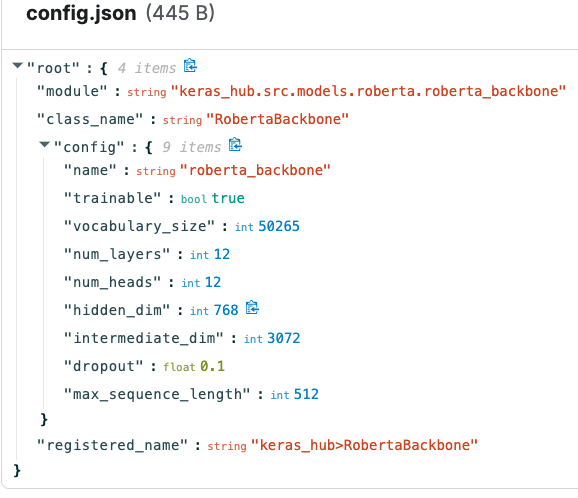

We will compile this model with a very conservative learning rate (why?) and will pick sparse categorical cross entropy for our loss (what does that loss function expect as labels?)

In [ ]:
# Re-compile (e.g., with a new learning rate).
classifier.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits='True'),
    optimizer=keras.optimizers.Adam(1e-5),
    metrics=["accuracy"],
    jit_compile=True,
)

In [ ]:
# Create a new column "Genre Int" that maps Rock to the integer 0,
# Pop to 1, and Hip Hop to 2

genre_mapping = {"Rock": 0, "Pop": 1, "Hip Hop": 2}
train_df["Genre_Int"] = train_df["Genre"].map(genre_mapping)
val_df["Genre_Int"] = val_df ["Genre"].map(genre_mapping)
test_df["Genre_Int"] = test_df ["Genre"].map(genre_mapping)

In [ ]:
train_df = train_df.sample(frac=1, random_state=42)
lyrics = train_df['Lyric'].tolist()
genre = train_df['Genre_Int'].tolist()

#sample_df has just 100 data points to train on
sample_df = train_df.sample(n=100, random_state=42)
sample_lyrics = sample_df['Lyric'].tolist()
sample_genre = sample_df['Genre_Int'].tolist()

sval_df = val_df.sample(frac=1, random_state=42)
val_lyrics = sval_df['Lyric'].tolist()
val_genre = sval_df['Genre_Int'].tolist()

test_df = test_df.sample(frac=1, random_state=42)
test_lyrics = test_df['Lyric'].tolist()
test_genre = test_df['Genre_Int'].tolist()

In [ ]:
sample_genre[:3]

[1, 0, 1]

In [ ]:
genre[:10]

[1, 0, 0, 0, 0, 0, 2, 0, 0, 0]

In [ ]:
# Fit the model with preprocessed data
history = classifier.fit(
    x=sample_lyrics,  # Use the preprocessed features
    y=sample_genre,    # Use the numerical labels
    batch_size=16,
    epochs=15,
    validation_data=(val_lyrics, val_genre)  # Preprocess validation data as well
)

Epoch 1/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 184s 17s/step - accuracy: 0.0727 - loss: 1.2130 - val_accuracy: 0.2947 - val_loss: 1.1258
Epoch 2/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 46s 7s/step - accuracy: 0.4151 - loss: 1.0862 - val_accuracy: 0.5469 - val_loss: 1.0343
Epoch 3/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 47s 8s/step - accuracy: 0.5452 - loss: 0.9695 - val_accuracy: 0.5498 - val_loss: 0.9642
Epoch 4/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 46s 7s/step - accuracy: 0.5452 - loss: 0.9088 - val_accuracy: 0.5498 - val_loss: 0.9150
Epoch 5/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 46s 7s/step - accuracy: 0.5452 - loss: 0.8708 - val_accuracy: 0.5498 - val_loss: 0.8726
Epoch 6/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 46s 7s/step - accuracy: 0.5502 - loss: 0.7703 - val_accuracy: 0.5727 - val_loss: 0.8293
Epoch 7/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 47s 8s/step - accuracy: 0.6009 - loss: 0.6969 - val_accuracy: 0.5907 - val_loss: 0.7937
Epoch 8/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 47s 7s/step - accuracy: 0.7510 - loss: 0.5984 - val_accuracy: 0.6621 - val_loss: 0.7528
Epoch 

Let's examine the training dynamic here:

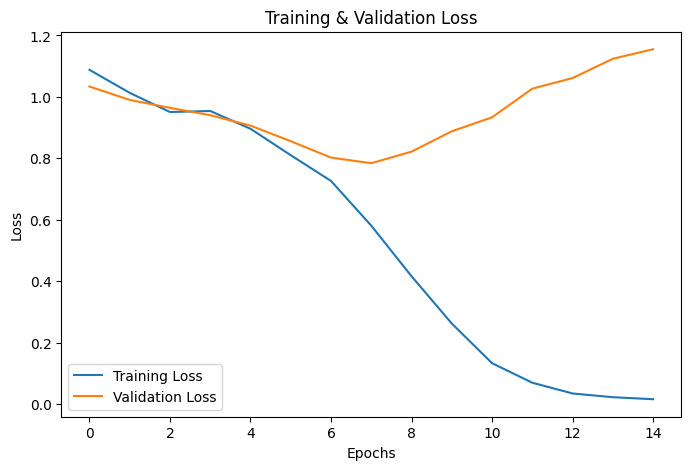

In [ ]:
import matplotlib.pyplot as plt

# Extract loss and accuracy data
train_loss = history.history["loss"]
val_loss = history.history["val_loss"]
train_acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]

# Plot Loss
plt.figure(figsize=(8, 5))
plt.plot(train_loss, label="Training Loss")
plt.plot(val_loss, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Training & Validation Loss")
plt.show()

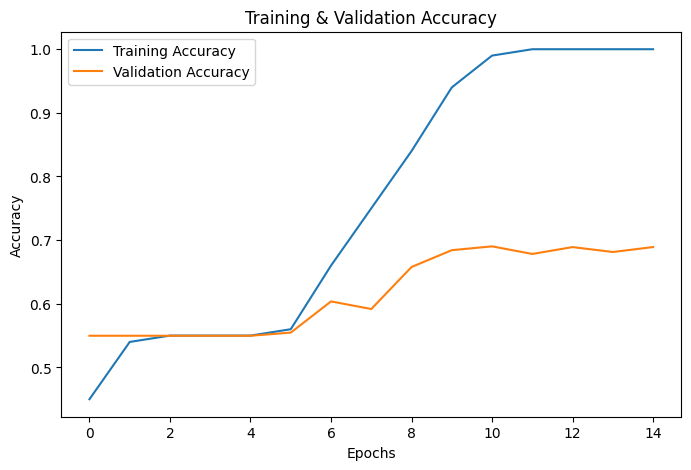

In [ ]:
# Plot Loss
plt.figure(figsize=(8, 5))
plt.plot(train_acc, label="Training Accuracy")
plt.plot(val_acc, label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Training & Validation Accuracy")
plt.show()

Perhaps not surprisingly, we eventually memorize the data (the train loss goes to zero with train accuracy going to 100%) since the model has massive capacity.

While the loss plot shows the validation loss bottoming out at 7 epochs, the accuracy plot shows the validation accuracy continuing to climb till the 9th epoch and not changing much from that point on. This sort of divergence between loss and accuracy plots is not uncommon. Since accuracy is the true metric we care about, I tend to place more importance on the accuracy picture. The val accuracy at the 15th epoch is close to the maximum validation accuracy achieved during the run so I am comfortable with the final model.


In [ ]:
classifier.evaluate(x=test_lyrics, y=test_genre)

681/681 ━━━━━━━━━━━━━━━━━━━━ 57s 74ms/step - accuracy: 0.6766 - loss: 1.1804


[1.1915960311889648, 0.6775512099266052]

We get to approximately 68% test accuracy *with just 100 training data points.* In contrast, BoW did not make any progress whatsoever with 100 data points, while it got to only about 74% accuracy with the entire dataset of ~50,000 (!) data points.